In [2]:
#!pip3 uninstall --yes torch torchaudio torchvision torchtext torchdata
#!pip3 install torch torchaudio torchvision torchtext torchdata
!pip3 install gymnasium

In [3]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque # queue for efficiently adding and removing elements from both ends
import gymnasium as gym
from gymnasium.envs.registration import register
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from gymnasium import spaces

import datetime
import os
import shutil

In [4]:
from math import cos, sin, pi
from mpl_toolkits.mplot3d import Axes3D

In [5]:
print(torch.__version__)

2.2.1+cu121


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [7]:
class LogStore():
    """_summary_
    This class is used to store the log information in a text file.

    _attributes_
    filename: str
        The name of the file to store the log information

    _methods_
    setfilename(name: str)
        Set the filename to store the log information
    write_to_log(input: str)
        Write the input to the log file
    """
    def __init__(self):
        self.filename = ""

    def setfilename(self,name):
        self.filename = name

    def write_to_log(self, input):
            with open(self.filename + ".txt", 'a') as log:
                log.write(input + "\n")

In [14]:
class RobotEnvironment(gym.Env):
    """_summary_: Custom Environment that follows gym interface for a 6-joint robot arm in a voxel space with a helix path.

        note:   Custom Environment that follows gym interface
                Every Gym environment must have the attributes action_space and observation_space (containing states).

    _gymnasium attributes_:

    action space: The action space consists of 6 discrete actions, one for each joint.
    state / observation space: The observation space consists of a 3D voxel grid and the current TCP position.

    _gymnasium methods_:

    - __init__(self, radius=0.03, height_per_turn=0.05, turns=2, resolution=0.001): Initializes the environment
    - step(self, action): Updates the environment with actions and returns the next agent observation, reward, and info.
    - reset(self, seed=None, options=None): Resets the environment to an initial internal state.
    - render(self): Visualizes the voxel space with the helix path and highlights the TCP position if provided.

    _custom methods_:

    - init_helix(self): Initializes a helix path in the voxel space.
    - is_on_helix(self, tcp_coords): Checks if the TCP coordinates lie on the helix path.
    - process_action(self, action): Processes the action provided to generate new joint angles.
    - init_translation_matrix(self): Initializes the translation matrix based on the initial TCP position.
    - translate_robot_to_voxel_space(self, point): Translates a point from robot space to voxel space.
    - update_tcp_position_in_voxel_space(self, new_tcp_position_robot_space): Updates the TCP position in voxel space.
    - dh_transform_matrix(self, a, d, alpha, theta): Computes the standard Denavit-Hartenberg transformation matrix.
    - forward_kinematics(self, theta_degrees): Calculates the end-effector position and orientation using the provided joint angles.
    - objective_function_with_orientation(self, theta, constant_orientation): Calculates the combined positional and orientational error.
    - find_closest_helix_point(self, current_tcp_position, helix_points): Finds the closest point on the helix to the current TCP position.
    - reward_function(self, tcp_on_helix): Calculates the reward based on the current state of the environment.

    """


    def __init__(self,  radius=0.03, height_per_turn=0.05, turns=2, resolution=0.001):
        # each joint can have one of three actions: decrease (-0.1°), keep (0.0°), increase (+0.1°)
        # represented as 0 (decrease), 1 (keep), 2 (increase) for each join
        self.action_space =  gym.spaces.MultiDiscrete([3, 3, 3, 3, 3, 3])  # 3^6 = 729 possible actions

        # define the helix
        self.radius = radius  # radius in meters
        self.height_per_turn = height_per_turn  # height per turn in meters
        self.turns = turns  # number of turns

        # voxel space dimensions
        self.x_range = (-self.radius, self.radius)
        self.y_range =  (-self.radius, self.radius)
        self.z_range = (0, self.height_per_turn*self.turns)
        self.resolution = resolution  # resolution: 1mm = 0.001m

        # dimensions of the voxel grid
        self.x_size = int((self.x_range[1]*2- self.x_range[0]*2) / self.resolution) + 1
        self.y_size = int((self.y_range[1] - self.y_range[0]) / self.resolution) + 1
        self.z_size = int((self.z_range[1] - self.z_range[0]) / self.resolution) + 1

        # combined observation space for voxel_space and TCP position
        num_channels = 2  # # spatial observation space setup for a two-channel input:
        self.tcp_data_length = 3  # 3 orientation angle values
        # combine the two observation spaces with gym.tuple: spatial data and TCP data
        self.observation_space = gym.spaces.Tuple((
            gym.spaces.Box(low=-1, high=1, shape=(num_channels, self.x_size, self.y_size, self.z_size), dtype=np.float64), #  spacial data observation space defined by dimensions and possible voxel values (-1 to 1)
            gym.spaces.Box(low=-360, high=360,
                                                shape=(self.tcp_data_length,),
                                                dtype=np.float64) # observation space for the TCP data
        ))

        # init voxel space
        self.voxel_space = np.full((self.x_size, self.y_size, self.z_size), -1)  # initialize all voxels with -1

        self.initial_joint_angles = np.array([0,0,0,0,0,0.0])  # initial joint angles
        self.initial_tcp_position, self.init_orientation = self.forward_kinematics(self.initial_joint_angles)  # initial end-effector position
        #print("Initial Robot TCP Position:", self.initial_tcp_position)
        #print("Orientierung (Roll, Pitch, Yaw):", self.init_orientation)

        self.joint_angles = self.initial_joint_angles  # set joint angles to initial joint angles

        # voxel space origin set to the initial TCP position:

        self.init_translation_matrix()
        # Populate the voxel space with a helix
        self.init_helix()

        self.tcp_position = self.translate_robot_to_voxel_space(self.initial_tcp_position)
        self.old_tcp_position = self.tcp_position
        #print("Initial Voxel TCP Position:", self.tcp_position)

        # # set the TCP position for the voxel space channel 2
        self.tcp_observation = self.embed_tcp_position(self.tcp_position)
        # stack to create a two-channel observation
        self.observation = np.stack([self.voxel_space, self.tcp_observation], axis=0)

        self.tcp_on_helix = self.is_on_helix(self.tcp_position)  # is the TCP is on the helix?
        #print("TCP on Helix:", self.tcp_on_helix)
        self.tcp_orientation= self.init_orientation
        self.reward = 0 # reward points
        self.terminated = False
        self.truncated = False
        self.out_of_voxel_space = False

        self.tcp_in_voxels = None

        # tcp orientation
        self.tolerance = 10 # 10 ° tolerance
        self.constant_orientation = (0, 0, 180)  # Roll-, pitch- und yaw in rad
        #self.last_orientation_deviation = 0  # Initialization of the variable for storing the previous orientation deviation
        #ori_hold = np.all(ori_diff <= self.tolerances[1]) or np.all(ori_diff >= (360-self.tolerances[1]))

        # tcp pos tolerance
        self.tolerance_tcp_pos = 0.002 #0.00142 # instead of 1 mm tolerance diagonale vom Voxel

        # helixpoints
        self.helix_points = 0

        # closest distance
        self.closest_distance = None
        self.closest_point = None

        # counter for figures names
        self.figure_count = 1

        # tcp_data
        self.tcp_data = np.asarray([self.init_orientation])

        # tuple of spatial and tcp data
        self.state = (self.observation, self.tcp_data)
        self.current_directory = None



    def step(self, action):
        """Updates an environment with actions returning the next agent observation,
        the reward for taking that actions,
        if the environment has terminated or truncated due to the latest action
        and information from the environment about the step, i.e. metrics, debug info.

        Args:
            action (np.array): action provided by the agent (array of 6 integers between 0 and 2)

        Returns:
            observation (state):  Tuple of stacked voxel_space and current position of the TCP (end-effector) in the 3D space
                                  and the TCP Orientation
            reward (float): Amount of reward due to the agent actions
            terminated (bool): A boolean, indicating whether the episode has ended successfully
            truncated (bool): A boolean, indicating whether the episode has ended prematurely
            info (dict): A dictionary containing other customizable information from the environment
        """
        # convert action to delta angles and apply them
        delta_angles = self.process_action(action)

        # Convert delta_angles to numpy array
        delta_angles = np.array(delta_angles)

        # Ensure delta_angles has the same dtype as self.joint_angles
        delta_angles = delta_angles.astype(self.joint_angles.dtype)

        #print("Joint Angles in step:", self.joint_angles)
        # update TCP position (based on the new joint angles - not on the delta angles)
        new_tcp_position_in_robot_space, self.tcp_orientation = self.forward_kinematics(self.joint_angles)  # self.joint_angles are updated in process_action
        #print("new_TCP Position in robot space (step):", new_tcp_position_in_robot_space)
        #print("new Orientierung (Roll, Pitch, Yaw) in step:", tcp_orientation)
        self.old_tcp_position = self.tcp_in_voxels # save the old tcp position in voxels for the reward function
        self.tcp_position = self.translate_robot_to_voxel_space(new_tcp_position_in_robot_space)
        #print("New Voxel TCP Position in step:", self.tcp_position)

        # set the TCP position for the voxel space channel 2
        self.tcp_observation = self.embed_tcp_position(self.tcp_position)

        # stack to create a two-channel observation
        spatial_data = np.stack([self.voxel_space, self.tcp_observation], axis=0)

        # tcp_data
        self.tcp_data = np.asarray([self.tcp_orientation])

        # tuple of spatial and tcp data
        self.state = (spatial_data, self.tcp_data)

        # is TCP on the helix?
        self.tcp_on_helix = self.is_on_helix(self.tcp_position)

        # update the reward (based on the new state)
        self.reward = self.reward_function(self.tcp_on_helix)

        # eventually also return an info dictionary (for debugging)
        info = {
            'robot_state': self.joint_angles.tolist(),
            'tcp_position_in_coordinates': self.tcp_position.tolist(), # current TCP position in voxel space
            'tcp_position_in_voxels': self.tcp_in_voxels, # current TCP position in voxel indices
            'closest_point': self.closest_point.tolist(), # closest point on the helix
            'closest_distance': self.closest_distance.tolist(), # closest distance to the helix
            'current_orientation': self.tcp_orientation, # current orientation of the TCP
            'tcp_on_helix': self.tcp_on_helix # is the TCP on the helix?
        }

        # has to return: new observation (state), reward, terminated(bool), truncated(bool) info(dict)
        # return the new observation (state), reward, done flag
        return self.state, self.reward, self.terminated, self.truncated, info


    def init_helix(self):
        """_summary_: Initialize a helix path in the voxel space.

        This function computes the coordinates of points along a helix path
        defined by the given radius, height per turn, and number of turns.
        """

        # initialize helix
        r = self.radius  # radius
        h = self.height_per_turn # height per turn
        helix_resolution = 200
        t = np.linspace(0, self.turns, num=int(self.turns*helix_resolution) ) # parameter t from 0 to 2 for 2 complete turns

        offset = self.radius
        helix_x = r * np.cos(2 * np.pi * t + np.pi)  + offset
        helix_y = r * np.sin(2 * np.pi * t + np.pi)
        helix_z = h * t

        # Initialize an empty list to store the helix points
        self.helix_points_list = []
        self.helix_points_list = [helix_x, helix_y, helix_z]

        # mark the voxels on the helix path:
        for i in range(len(helix_x)):
            x_idx = int(round((helix_x[i] - self.x_range[0]) / self.resolution))
            y_idx = int(round((helix_y[i] - self.y_range[0]) / self.resolution))
            z_idx = int(round((helix_z[i] - self.z_range[0]) / self.resolution))
            #self.helix_points_list.append([x_idx, y_idx, z_idx])
            if 0 <= x_idx < self.x_size and 0 <= y_idx < self.y_size and 0 <= z_idx < self.z_size:
                if i == len(helix_x) - 1:  # last helix point
                    self.voxel_space[x_idx, y_idx, z_idx] = 1
                else:
                    self.voxel_space[x_idx, y_idx, z_idx] = 0  # helix path
            else:
               pass
               # print(f"Helix point out of bounds: {x_idx}, {y_idx}, {z_idx}")


        # Convert the list of indices to a numpy array and store it in self.helix_points
        self.helix_points = np.array(self.helix_points_list)

        # Print the helix points
        #print("Helix points:")
        #print(self.helix_points)

    def is_on_helix(self, tcp_coords):
        """_summary_Check if the TCP (Tool Center Point) coordinates lie on the helix path.

        This function converts the TCP coordinates to voxel indices within the voxel space
        and determines whether the TCP is on the helix path, at the target/end of the helix,
        or outside the helix voxels.

        Parameters:
            tcp_coords (tuple): The TCP coordinates in the form of (x, y, z).

        Returns:
            bool: True if TCP is on the helix path or at the target, False otherwise.
        """
        # convert TCP coordinates to voxel indices. Therefore find the relative position of the TCP
        # within the bounds  `x_range`, `y_range`, and `z_range`
        # scale this position to the resolution of the voxel grid:
        x_idx = int(round((tcp_coords[0] - self.x_range[0]) / self.resolution))
        y_idx = int(round((tcp_coords[1] - self.y_range[0]) / self.resolution))
        z_idx = int(round((tcp_coords[2] - self.z_range[0]) / self.resolution))

        #print(f"TCP coords: {tcp_coords} -> Voxel indices: x:{x_idx}, y:{y_idx}, z:{z_idx}")  # debugging info
        self.tcp_in_voxels= [x_idx, y_idx, z_idx]
        # check if these indices are in the voxel space. If not, the TCP is outside the voxel space.
        if 0 <= x_idx < self.voxel_space.shape[0] and 0 <= y_idx < self.voxel_space.shape[1] and 0 <= z_idx < self.voxel_space.shape[2]:
            # get value of the voxel at the calculated indices. check if voxel
            # is on the helix path (0), the target/end of the helix (1), or outside the helix voxels (-1).
            voxel_value = self.voxel_space[x_idx, y_idx, z_idx]

            # if the TCP has reached the target (voxel-value = 1):
            if voxel_value == 1:
                #print("TCP reached the target!")
                self.terminated = True
                self.out_of_voxel_space = False
                return True  # TCP is on the helix

            # TCP is on a voxel of helix path but has not yet reached the end yet (voxel-value = 0):
            elif voxel_value == 0:
                #print("TCP is on the helix path.")
                self.out_of_voxel_space = False
                return True # TCP is on the helix path

            elif voxel_value == -1:
                # Check if the distance to the helix is less than or equal to 0.001
                self.closest_point, self.closest_distance = self.find_closest_helix_point(tcp_coords, self.helix_points)
                #max_distance = np.max(closest_distance)
                if self.closest_distance <= self.tolerance_tcp_pos:
                    #print("TCP is close to the helix.")
                    self.truncated = False
                    self.out_of_voxel_space = False
                    return True
                else:
                   # print("TCP is outside the helix voxels.")
                    self.truncated = True
                    self.out_of_voxel_space = False
                    return False

        else:
            self.truncated = True
           # print("TCP is outside the voxel space.")
            # otherwise the TCP is not on the helix path any more
            self.out_of_voxel_space = True
            return False



    def reset(self, seed=None, options=None):
        """_summary_: Resets the environment to an initial internal state, returning an initial observation and info.

        Returns:
            observsation (state): Observation of the initial state.
                                            This will be an element of observation_space (typically a numpy array)
                                            and is analogous to the observation returned by step()
            info(dict): A dictionary containing additional information about the environment
                            analogous to the info returned by step()
        """
        # reset the environment
       # print("__________________Resetting the environment...___________________")
        _ = seed  # acknowledging the seed parameter without using it to fit the gymnasium requirements
        self.voxel_space.fill(-1)

        self.initial_joint_angles = np.array([0,0,0,0,0,0.0])  # initial joint angles
        # self.initial_tcp_position = self.forward_kinematics(self.initial_joint_angles)  # initial end-effector position
        self.joint_angles = self.initial_joint_angles  # set joint angles to initial joint angles
        # voxel space origin set to the initial TCP position:
        #print("Initial TCP Position (Reset):", self.initial_tcp_position)
        self.init_translation_matrix()
        # Populate the voxel space with a helix
        self.init_helix()
        self.tcp_position = self.translate_robot_to_voxel_space(self.initial_tcp_position)

        #print("Voxel TCP Position (Reset):", self.tcp_position)
        # reset the joint angles and TCP position to the start of the helix

        self.tcp_observation = self.embed_tcp_position(self.tcp_position) # initial end-effector position

        # Stack to create a two-channel observation
        self.spatial_data= np.stack([self.voxel_space, self.tcp_observation], axis=0)

        # tcp_data
        self.tcp_data = np.asarray([self.init_orientation])

        # tuple of spatial and tcp data
        self.state = (self.spatial_data, self.tcp_data)

        # reset the reward and Flags
        self.tcp_on_helix = self.is_on_helix(self.tcp_position)
        self.reward = 0
        self.terminated= False
        self.truncated = False

        # counter for figures names
        self.figure_count = 1

        # eventually also return an info dictionary (for debugging)
        info = {
            'robot_state': self.initial_joint_angles.tolist(),
            'tcp_position': self.tcp_position.tolist()
        }

        return self.state, info #  self.joint_angles  # also return the joint angles?


    def reward_function(self, tcp_on_helix):
        """Calculate the reward based on the current TCP position."""
        self.reward = 0
        #closest_point, closest_distance = self.find_closest_helix_point(, self.helix_points)
        _, orientation_deviation, _ = self.objective_function_with_orientation()  # Roll, Pitch, Yaw in Grad

        # initialize reward, terminated, and truncated flags
        if tcp_on_helix and self.tcp_in_voxels[2] > self.old_tcp_position[2]:
            self.reward += 25
            self.truncated = False
        elif self.tcp_in_voxels[2] < self.old_tcp_position[2]:
            self.reward -= 25
        if self.terminated:
            self.reward += 1000 # extra reward for reaching the target

        if self.truncated:
             # terminate the episode if the tcp is not on the helix any more
            self.reward -=1

        # Adjust reward based on orientation deviation
        orientation_reward = 0
        max_deviation = np.max(orientation_deviation)
        print("max_deviation (in reward)", np.round(max_deviation,2))
        print("orientation_tolerance", self.tolerance)
        if max_deviation < self.tolerance and self.tcp_in_voxels[2] > self.old_tcp_position[2]:
            orientation_reward = 5
        else:
            orientation_reward = 0

        if self.out_of_voxel_space:
            self.reward -= 10
        # Add orientation reward to total reward
        self.reward += orientation_reward

        return self.reward


    def render(self):
        """_summary_: This function visualizes the voxel space with the helix path and highlights the TCP position
        """
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(*np.where(self.voxel_space == 1), c='r', s=40, alpha=1)  # helix end points
        ax.scatter(*np.where(self.voxel_space == 0), c='orange', s=40, alpha=0.25)  # helix path points

        # if TCP coordinates are provided and valid, then visualize TCP position
        if self.tcp_position is not None:
            #print(f"Is TCP on Helix Path: {is_on_path}")

            # convert real-world coordinates to indices for visualization
            x_idx = (self.tcp_position[0] - self.x_range[0]) / self.resolution
            y_idx = (self.tcp_position[1] - self.y_range[0]) / self.resolution
            z_idx = (self.tcp_position[2] - self.z_range[0]) / self.resolution

            # highlight TCP position
        ax.scatter([x_idx], [y_idx], [z_idx], c='b', s=80, alpha= 1, label='TCP Position')
        # Erstellen Sie den Pfeil für die Orientierung
        #ax.quiver(x_idx, y_idx, z_idx, self.tcp_orientation[0], self.tcp_orientation[1], self.tcp_orientation[2], color='black', length=15, normalize=True, arrow_length_ratio=0.2, linewidth=1)
        ax.quiver(x_idx, y_idx, z_idx, self.tcp_orientation[0], self.tcp_orientation[1], self.tcp_orientation[2], color='black', length=15, normalize=True, arrow_length_ratio=0.2, linewidth=1)
        # Set axis limits to start from 0
        #ax.set_xlim(0, self.x_size)
        #ax.set_ylim(0, self.y_size)
        #ax.set_zlim(0, self.z_size)
        ax.set_xlabel('X Index')
        ax.set_ylabel('Y Index')
        ax.set_zlabel('Z Index')
        ax.set_title('3D Plot of the Voxel Space')
        #plt.legend()
        #plt.show()

        # Create directory if not exists
        if not os.path.exists('ParamCombi1'):
            os.makedirs('ParamCombi1')
        # Create directory if not exists
        if not os.path.exists('ParamCombi2'):
            os.makedirs('ParamCombi2')

        # to check if a new episode has started
        new_episode = False

        # check if one of the folders contains the MSE file:
        # Specify the folder path and the filename
        folder_path1 = 'ParamCombi1'
        folder_path2 = 'ParamCombi2'
        filename = 'MSE.png'

        # Construct the full path to the file
        file_path1 = os.path.join(folder_path1, filename)
        file_path2 = os.path.join(folder_path2, filename)

        if os.listdir('ParamCombi1') == [] and os.listdir('ParamCombi2') == []:
            new_episode = True

        # check if the MSE file exists in folder (this means that this folders episode has ended)
        if os.path.exists(file_path1):
            if os.path.exists(file_path2):
                new_episode = True
        elif os.path.exists(file_path2) and os.listdir('ParamCombi1') == []:
                new_episode = True
        elif os.path.exists(file_path1) and os.listdir('ParamCombi2') == []:
                new_episode = True


        if new_episode:
            #print("New Episode")
            # check which folder contains more elements and delete the one with less elements and save in the folder which has less files
            num_files_in_ParamCombi1 = len(os.listdir("ParamCombi1"))
            num_files_in_ParamCombi2 = len(os.listdir("ParamCombi2"))

            if num_files_in_ParamCombi1 >= num_files_in_ParamCombi2:
                    self.current_directory = 2
                    #print("Current Directory: 2")
                    shutil.rmtree('ParamCombi2')
                    os.makedirs('ParamCombi2')
                    plt.savefig(os.path.join('ParamCombi2', f'step_{self.figure_count}.png'))
            else:
                    self.current_directory = 1
                    #print("Current Directory: 1")
                    shutil.rmtree('ParamCombi1')
                    os.makedirs('ParamCombi1')
                    plt.savefig(os.path.join('ParamCombi1', f'step_{self.figure_count}.png'))
        else:
            if self.current_directory == 1:
                # Save the figure in folder 1
                plt.savefig(os.path.join('ParamCombi1', f'step_{self.figure_count}.png'))
            else:
                # Save the figure in folder 2
                plt.savefig(os.path.join('ParamCombi2', f'step_{self.figure_count}.png'))

        plt.close() # close the figure

        self.figure_count += 1 # increment the figure count


    def process_action(self, action):
        """_summary_: Process the action provided to generate new joint angles.

        This function calculates the delta angles for each action and updates the joint angles accordingly.
        The delta angles are calculated based on the action values provided, and the joint angles are limited
        within the range of -180 to 180 degrees.

        Parameters:
            action: The action values to be processed.

        Returns:
            np.ndarray: The delta angles resulting from the action processing.
        """
        # Check if action is iterable
        if isinstance(action, (list, tuple)):
        # If yes, calculate the delta angles for each action
            delta_angles = np.array([(a - 1) * 0.1 for a in action])
            #print("Delta Angles (process action):", delta_angles)
        else:
        # Otherwise, there is only one action, so calculate the delta angle directly
            delta_angles = np.array([(action - 1) * 0.1])

        #print("joint_angles (process action):", self.joint_angles)
        new_angles = self.joint_angles + delta_angles

        # Limit the new joint angles within the range of -180 to 180 degrees
        self.joint_angles = np.clip(new_angles, -180, 180)
        #print("New Joint Angles (process action):", self.joint_angles)
        # Return the delta angles
        return delta_angles

    def init_translation_matrix(self):
        """_summary_: Initialize the translation matrix based on the initial TCP position.

        This function computes the translation vector as the negative of the initial TCP position,
        and constructs the translation matrix accordingly.
        """
        # self.initial_tcp_position is the initial TCP position
        # the translation vector is the negative of this position
        translation_vector = -self.initial_tcp_position
        # translation matrix:
        self.translation_matrix = np.array([
            [1, 0, 0, translation_vector[0]],
            [0, 1, 0, translation_vector[1]],
            [0, 0, 1, translation_vector[2]],
            [0, 0, 0, 1]
        ])

    def translate_robot_to_voxel_space(self, point):
        """_summary_: Translate a point from robot space to voxel space."""
        # convert the point to homogeneous coordinates for matrix multiplication
        homogeneous_point = np.append(point, 1)
        # apply the translation matrix
        translated_point_homogeneous = np.dot(self.translation_matrix, homogeneous_point)
        # convert back to cartesian coordinates
        translated_point = translated_point_homogeneous[:3]
        return translated_point

    def update_tcp_position_in_voxel_space(self, new_tcp_position_robot_space):
        """_summary_: Update the TCP position in voxel space."""
        # translate new TCP position to voxel space
        translated_position = self.translate_robot_to_voxel_space(new_tcp_position_robot_space)
        # convert translated position to voxel indices
        x_idx, y_idx, z_idx = self.position_to_voxel_indices(translated_position)
        # update voxel grid as needed
        return x_idx, y_idx, z_idx

    def dh_transform_matrix(self,a, d, alpha, theta):
        """_summary_: Compute the standard Denavit-Hartenberg transformation matrix.

        This function computes the standard Denavit-Hartenberg transformation matrix based on the provided DH parameters.
        The transformation matrix is computed using the cosine and sine functions of the given angles.

        Parameters:
            a: The link length.
            d: The link offset.
            alpha: The link twist angle.
            theta: The joint angle.

        Returns:
            np.ndarray: The computed transformation matrix.
        """

    ## compute the standard Denavit-Hartenberg transformation matrix.
    ## source: wikipedia
        return np.array([
                [np.cos(theta), -np.sin(theta) * np.cos(alpha), np.sin(theta) * np.sin(alpha), a * np.cos(theta)],
                [np.sin(theta), np.cos(theta) * np.cos(alpha), -np.cos(theta) * np.sin(alpha), a * np.sin(theta)],
                [0, np.sin(alpha), np.cos(alpha), d],
                [0, 0, 0, 1]
            ])

    def forward_kinematics(self, theta_degrees):
        """_summary_: Calculate the TCP position and orientation using the provided joint angles.

        This function computes the TCP position and orientation based on the Denavit-Hartenberg (DH) parameters
        and the given joint angles.

        Parameters:
            theta_degrees: Joint angles in degrees.

        Returns:
            tuple: A tuple containing the TCP position (x, y, z) and orientation angles (alpha, beta, gamma).
        """
        theta = np.radians(theta_degrees) # convert angles from degree to radians for cos and sin functions
        # DH parameters for each joint: (a, d, alpha, theta)
        dh_params = [
            (0, 0.15185, np.pi/2, theta[0]),
            (-0.24355, 0, 0, theta[1]),
            (-0.2132, 0, 0, theta[2]),
            (0, 0.13105, np.pi/2, theta[3]),
            (0, 0.08535, -np.pi/2, theta[4]),
            (0, 0.0921, 0, theta[5])
        ]

        T = np.eye(4)
        for i, params in enumerate(dh_params):
            #a, d, alpha, theta_val = params
            #print(f"DH Parameters for joint {i}: a={a}, d={d}, alpha={alpha}, theta={theta_val}")

            T_i = self.dh_transform_matrix(*params)
            #print(f"Transformation Matrix T{i}:\n{T_i}\n")

            # Überprüfe die Form der Transformationsmatrix
            if T_i.shape != (4, 4):
                raise ValueError(f"Unexpected shape of transformation matrix T{i}: {T_i.shape}. Expected (4, 4)")

            T = np.dot(T, T_i)
        #print(f"Final Transformation Matrix T:\n{T}\n")  # Neu hinzugefügter Code

        # for params in dh_params:
        #     T = np.dot(T, self.dh_transform_matrix(*params))

        # extract position from the final transformation matrix
        position = T[:3, 3]
        # extract rotation matrix from devanit-hartenberg matrix
        rotation_matrix = T[:3, :3]
        # # https://de.wikipedia.org/wiki/Roll-Nick-Gier-Winkel
        # calculate beta
        beta = np.arctan2(-rotation_matrix[2, 0], np.sqrt(rotation_matrix[0, 0]**2 + rotation_matrix[1, 0]**2))

        # calculate alpha
        alpha = np.arctan2(rotation_matrix[1, 0] / np.cos(beta), rotation_matrix[0, 0] / np.cos(beta))

        # calculate gamma
        gamma = np.arctan2(rotation_matrix[2, 1] / np.cos(beta), rotation_matrix[2, 2] / np.cos(beta))

        # normalize angles
        alpha, beta, gamma = alpha % (2*np.pi), beta % (2*np.pi), gamma % (2*np.pi)

        # convert angles to degrees
        alpha,beta,gamma = np.rad2deg([alpha,beta,gamma])

        self.tcp_orientation = (alpha, beta, gamma)
        #print("position_tcp: ", position)
        return position, (alpha, beta, gamma)


    def objective_function_with_orientation(self): # closes_target_pos
        """_summary_: Calculate the error based on the current position and orientation.
        """
        # Calculate the current position and orientation from forward kinematics
        #current_position, current_orientation = self.forward_kinematics(theta) # joint angle
        #current_position = self.translate_robot_to_voxel_space(current_position)
        # get closest point (closest_target_pos)xxx
        #print("current_tcp_pos_in_voxel_space (objective func):", current_position)
        closest_helix_point, closest_distance = self.find_closest_helix_point(self.tcp_position, self.helix_points)

        # Format the orientation to two decimals
        #formatted_orientation = [f'{num:.2f}' for num in current_orientation]
        # print(formatted_orientation)

        # Convert orientation tuples to numpy arrays
        current_orientation = np.array(self.tcp_orientation)
        constant_orientation = np.array(self.tcp_orientation)   # const. orientation = (0,0,180)

        # Calculate the positional error
        position_error = np.linalg.norm(current_orientation - np.array(closest_helix_point))
        print("Position error", position_error)
        # deviation of current and constant orientation
        orientation_errors = np.abs(current_orientation - self.constant_orientation)
        print("orientation error", orientation_errors)
        # Combine errors, possibly with weighting factors if needed
        #total_error = position_error + orientation_error

        return position_error, orientation_errors, closest_distance



    def find_closest_helix_point(self, current_tcp_position, helix_points):
        """_summary_: Find the closest point on the helix to the current TCP position."""

        # calculate distance between every helix point and every current tcp position
        differences = helix_points - current_tcp_position.reshape(3, 1)
        distances = np.linalg.norm(differences, axis=0)

        # find index with smallest distance
        closest_index = np.argmin(distances)

        # Return of the point on the helix closest to the current TCP position and the corresponding distance
        closest_point = helix_points[:, closest_index]
        closest_distance = distances[closest_index]

        #print("closest point ", closest_point)
        #print("closest distance ", np.round(closest_distance,4)) # double
        #x_idx = int(round(closest_point[0] / self.resolution))
        x_idx = (closest_point[0] - self.x_range[0]) / self.resolution
        y_idx = (closest_point[1] - self.y_range[0]) / self.resolution
        z_idx = (closest_point[2] - self.z_range[0]) / self.resolution
        test = [ x_idx,  y_idx,  z_idx]
        #print("closest_point invoxel_space", test)
        self.closest_distance = closest_distance
        self.closest_point = closest_point

        return closest_point, closest_distance



    def position_to_voxel_indices(self, point_in_voxel_space):
        """_summary_:
        This function converts the coordinates of a point in voxel space to voxel indices,
        considering the resolution of the voxel grid.

        Parameters:
            point_in_voxel_space: The coordinates of the point in voxel space.

        Returns:
            tuple: A tuple containing the voxel indices (x_idx, y_idx, z_idx) of the given point.
        """
        # point_in_voxel_space already needs to be translated to voxel space
        x_idx = int(round(point_in_voxel_space[0] / self.resolution))
        y_idx = int(round(point_in_voxel_space[1] / self.resolution))
        z_idx = int(round(point_in_voxel_space[2] / self.resolution))
        return x_idx, y_idx, z_idx

    def embed_tcp_position(self, tcp_position):
        """_summary_: Embeds the TCP position in a 3D grid of the same shape as the voxel space."""
        grid = np.zeros(self.voxel_space.shape, dtype=np.float32)
        # TCP position to grid index + set to 1
        #x_idx, y_idx, z_idx = self.tcp_position_to_grid_index(tcp_position)
        x_idx, y_idx, z_idx = self.position_to_voxel_indices(tcp_position)
        try:
            grid[x_idx, y_idx, z_idx] = 1
        except:
            pass
     #       print("TCP Position Indices out of bounds!")
        #print("TCP Position Grid:", grid)
        return grid

Learning Part:

In [10]:
torch.set_default_dtype(torch.float)

In [9]:
class QNetworkCNN(nn.Module):
    """_summary_
    This class defines the Q-network
    using a Multimodal Approach: Convolutional Neural Network (CNN) architecture for the spatial data
    and Late Feature Fusion for the TCP orientation data to predict the Q-values for the actions.

    _attributes_
    conv1 & conv2: nn.Conv3d
        3-Dimensionaler Convolutional layer
    pool: nn.MaxPool3d
        3-Dimensionaler MaxPooling layer
    flat_features: int
        The number of flat features calculated from the convolutional layers
    fc1 & fc2: nn.Linear
        Fully connected layers

    _methods_
    forward(x, tcp_data)
        Forward pass through the network
    calculate_flat_features(dummy_input)
        Calculate the number of flat features from the convolutional layers
    """
    def __init__(self, state_size, actions, tcp_feature_size=3):
        super(QNetworkCNN, self).__init__()
        # Initialize convolutional and pooling layers
        self.conv1 = nn.Conv3d(in_channels=state_size[0], out_channels=16, kernel_size=3, stride=1, padding=1, dilation=1)
        self.pool = nn.MaxPool3d(2, 2)
        self.conv2 = nn.Conv3d(16, 128, kernel_size=5, stride=1, padding=1, dilation=2)
        self.conv3 = nn.Conv3d(128, 32, kernel_size=3, stride=1, padding=1, dilation=2)

        # Use a dummy input to calculate flat features
        self.flat_features = self.calculate_flat_features(torch.zeros(1, state_size[0], state_size[1], state_size[2], state_size[3]).float())

        # Initialize fully connected layers using the calculated flat_features
        self.fc1 = nn.Linear(self.flat_features + tcp_feature_size, 512)
        self.fc2 = nn.Linear(512, 256)
        #self.dropout = nn.Dropout(p=0.20)  # Dropout layer
        self.fc3 = nn.Linear(256, actions*3)   # 3 possible values per action component

    def forward(self, x, tcp_data):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        # concatenate flattened spatial data with TCP position and orientation data
        #print("x shape:", x.shape)
        #print("tcp_data shape:", tcp_data.shape)
        tcp_data= torch.squeeze(tcp_data, dim=1)
        combined_features = torch.cat((x, tcp_data), dim=1)

        x = F.relu(self.fc1(combined_features))
        #x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(-1, 6, 3)

    def calculate_flat_features(self, dummy_input):
        # Pass the dummy input through the convolutional and pooling layers
        with torch.no_grad():
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
        # The output's total size is the required number of flat features
        return x.numel() // x.shape[0]  # Divide by batch size (x.shape[0]) to get the size per sample





In [11]:
class DQNAgent:
    """_summary_
    This class defines the DQN agent that interacts with the environment.
    The agent uses a Q-network to predict the Q-values for the actions and learns from the experiences in the memory.

    _attributes_
    spatial_data_shape: tuple
        The shape of the spatial data
    actions: int
        The number of actions
    epsilon: float
        The exploration rate
    epsilon_decay: float
        The rate at which the epsilon value decays
    epsilon_min: float
        The minimum value of epsilon
    device: str
        The device to run the computations on
    lr: float
        The learning rate
    gamma: float
        The discount factor
    batch_size: int
        The batch size
    buffer_size: int
        The size of the memory buffer
    n_step: int
        The number of steps to calculate the n-step return
    n_step_buffer: deque
        A temporary buffer for n-step calculation
    memory: deque
        The memory buffer to store experiences
    q_network: QNetworkCNN
        The Q-network to predict Q-values
    target_network: QNetworkCNN
        The target network to predict Q-values
    optimizer: optim.Adam
        The optimizer to update the weights of the Q-network

    _methods_
    add_experience(spatial_data, tcp_data, action, reward, next_spatial_data, next_tcp_data, done)
        Add the experience to the memory
    calculate_n_step_info()
        Calculate the n-step reward, final state, and done status
    act(state)
        Choose an action based on the epsilon-greedy policy
    replay()
        Learn from the experiences in the memory
    update_target_network()
        Update the target network with the weights of the Q-network
    """

    def __init__(self, spatial_data_shape, actions, epsilon_decay, epsilon_min, batch_size, device, lr=5e-4, gamma=0.99, buffer_size=10000, n_step=3):
        self.spatial_data_shape = spatial_data_shape
        self.actions = actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.n_step_buffer = deque(maxlen=n_step)  # temporary buffer for n-step calculation
        self.n_step = n_step
        # this ensures that the memory does not grow beyond buffer_size - oldest elements are removed:
        self.memory = deque(maxlen=buffer_size)

        self.q_network = QNetworkCNN(self.spatial_data_shape, actions, tcp_feature_size=3).to(device)
        self.target_network = QNetworkCNN(self.spatial_data_shape, actions, tcp_feature_size=3).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        self.epsilon = 1
        self.epsilon_decay = epsilon_decay #0.995  # 0.9 for debugging only
        self.epsilon_min = epsilon_min

    def add_experience(self, spatial_data, tcp_data, action, reward, next_spatial_data, next_tcp_data,done):
        # keep experience in n-step buffer
        experience = ((spatial_data, tcp_data), action, reward, (next_spatial_data, next_tcp_data), done)
        self.n_step_buffer.append(experience)

        if len(self.n_step_buffer) == self.n_step or done:
            n_step_reward, n_step_state, n_step_done = self.calculate_n_step_info()
            # keep n-step transition in memory
            self.memory.append((self.n_step_buffer[0][0], self.n_step_buffer[0][1], n_step_reward, n_step_state, n_step_done))

            if done:
                # Clear the buffer if the episode ended
                self.n_step_buffer.clear()

    def calculate_n_step_info(self):
        """_summary_
        Calculate the n-step reward, final state, and done status

        _returns_
        n_step_reward: float
            The n-step reward
        n_step_state: tuple
            The final state
        n_step_done: bool
            The done status
        """
        n_step_reward = 0
        for idx, (_, _, reward, _, _) in enumerate(self.n_step_buffer):
            n_step_reward += (self.gamma ** idx) * reward
        # The final state and done flag from the last experience
        _, _, _, n_step_state, n_step_done = self.n_step_buffer[-1]
        return n_step_reward, n_step_state, n_step_done


    def act(self, state):
        """_summary_
        Choose an action based on the epsilon-greedy policy

        _parameters_
        state: tuple
            The current state

        _returns_
        action: list
            The chosen action
        exploiting: bool
            The exploitation status
        """

        exploiting  =  False
        spatial_data, tcp_data = state  # unpack the state tuple
        if np.random.rand() <= self.epsilon:
            # return random action for each component
            action = [random.randrange(3) for _ in range(6)]
            print("exploring: random action")
            #print("action shape:", len(action))
            return action, exploiting # shape [6] ?

        spatial_data = torch.FloatTensor(spatial_data).unsqueeze(0).to(device)
        tcp_data = torch.FloatTensor(tcp_data).unsqueeze(0).to(device)
        q_values = self.q_network(spatial_data, tcp_data)
        print("exploiting: q-values predicted from network") # q-values: torch.Size([1, 6, 3])
        exploiting = True
        # choose action with max Q-value for each component
        action = q_values.detach().cpu().numpy().argmax(axis=2).flatten()
        action = action.tolist()
        #print("action shape:", len(action))
        print("-------------------------------")
        print("action:", action)
        print("exploiting:", exploiting)
        return action, exploiting


    def replay(self):
        """_summary_
        Learn from the experiences in the memory
        """
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        #states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(np.array(actions)).to(device)
        rewards = torch.FloatTensor(np.array(rewards)).to(device).view(-1) # shape [batch_size]
        #next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(np.array(dones)).to(device) # dones is terminated or truncated states
        # convert actions to long tensor for indexing
        actions = actions.long()
        # actions is of shape [batch_size], containing the index of the action taken for each batch item
        actions = actions.view(-1, 6, 1)  # reshape for gathering: [batch_size*6, 1]
        #states = states.float() # Ensure states is a FloatTensor

        # states includes both spatial and TCP data
        # spatial_data, tcp_data = states  # This line might need to be adjusted based on your data storage format
        # spatial_data = torch.stack(spatial_data).to(device)  # Convert list of tensors to a single tensor
        # tcp_data = torch.stack(tcp_data).to(device)  # Convert list of tensors to a single tensor

        # separate spatial and TCP data for states and next_states
        spatial_data = torch.stack([torch.FloatTensor(state[0]) for state in states]).to(device)
        tcp_data = torch.stack([torch.FloatTensor(state[1]) for state in states]).to(device)

        next_spatial_data = torch.stack([torch.FloatTensor(state[0]) for state  in next_states]).to(device)
        next_tcp_data = torch.stack([torch.FloatTensor(state[1]) for state in next_states]).to(device)

        # get the q-values from the q-network for the current states
        Q_values = self.q_network(spatial_data, tcp_data) # this returns Q(s,a) for all actions a
        # get the q-values for the actions taken
        Q_expected = Q_values.gather(2, actions).squeeze(-1)  # --> shape [batch_size, 6]

        # get the q-values from the target network for the next states
        Q_values_next = self.target_network(next_spatial_data, next_tcp_data).detach()
        Q_targets_next = Q_values_next.max(dim=2)[0]  # max along the last dimension --> shape [batch_size, 6]

        # not terminated or truncated states:
        not_done = 1 - (dones)
        not_done = not_done.to(device).view(-1)  # Ensure shape [batch_size]

        # shape rewards and not_done to [batch_size, 6]
        rewards_expanded = rewards.unsqueeze(1).expand_as(Q_targets_next)  # Expands to [batch_size, 6]
        not_done_expanded = not_done.unsqueeze(1).expand_as(Q_targets_next)  # Expands to [batch_size, 6]

        ## n-step bootstrap state to calculate the next Q-values:
        Q_targets = rewards_expanded + (self.gamma**self.n_step * Q_targets_next * not_done_expanded)

        # compute loss, perform backpropagation and update weights:
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            #print("epsilon reduced:", self.epsilon)

    def update_target_network(self):
        """_summary_
        Update the target network with the weights of the Q-network
        """
        self.target_network.load_state_dict(self.q_network.state_dict())


In [ ]:
# Helperfunctions to save the weights of the (partly) trained model

def save_model_weights(agent, file_path):
    """Save the weights of the agent's Q-network to a file."""
    torch.save(agent.q_network.state_dict(), file_path)
def load_model_weights(agent, file_path):
    """Load the weights of the Q-network from a file."""
    agent.q_network.load_state_dict(torch.load(file_path))

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment RobotEnvironment-v3 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
-------------------------------
action: [2, 1, 0, 0, 0, 0]
exploiting: True
Position error 90.0256036412976
orientation error [ 1.00015235  1.49996191 89.99127092]
max_deviation (in reward) 89.99
orientation_tolerance 10
exploiting: q-values predicted from network
-------------------------------
action: [2, 1, 0, 0, 0, 0]
exploiting: True
Position error 90.03716862466246
orientation error [ 1.20026328  1.79993418 89.98742857]
max_deviation (in reward) 89.99
orientation_tolerance 10
exploiting: q-values predicted from network
-------------------------------
action: [2, 1, 0, 0, 0, 0]
exploiting: True
Position error 90.05111298073555
orientation error [ 1.40041814  2.09989547 89.98288641]
max_deviation (in reward) 89.98
orientation_tolerance 10
exploiting: q-values predicted from network
-------------------------------
action: [2, 1, 0, 0, 0, 0]
exploiting: True
Position error 90.06697067088773
orientation error [ 1.60062

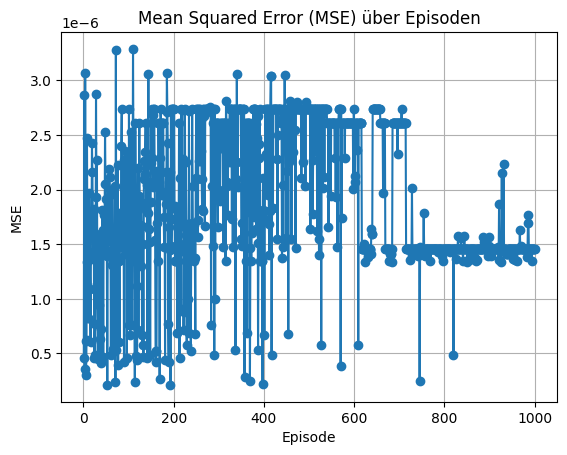

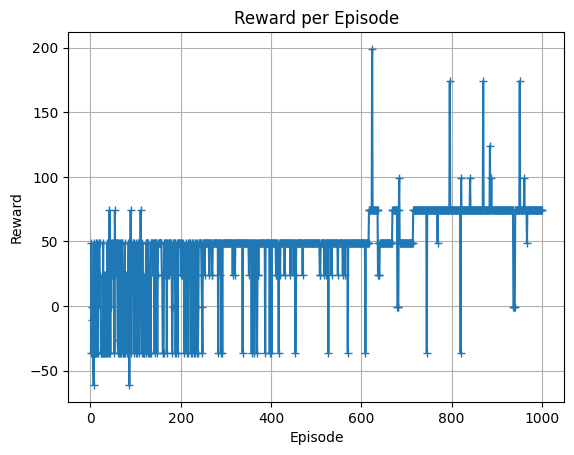

In [15]:
# grid for hyperparameters grid search
grid = [#{'batch_size': 8, 'episodes': 10, 'epsilon_decay': 0.9, 'epsilon_min': 0.25},
        #{'batch_size': 8, 'episodes': 100, 'epsilon_decay': 0.95, 'epsilon_min': 0.1},
        #{'batch_size': 8, 'episodes': 100, 'epsilon_decay': 0.995, 'epsilon_min': 0.2},
        #{'batch_size': 16, 'episodes': 100, 'epsilon_decay': 0.9, 'epsilon_min': 0.2},
        #{'batch_size': 32, 'episodes': 500, 'epsilon_decay': 0.9995, 'epsilon_min': 0.2},
        #{'batch_size': 64, 'episodes': 1000, 'epsilon_decay': 0.99, 'epsilon_min': 0.2},
        #{'batch_size': 32, 'episodes': 200, 'epsilon_decay': 0.9, 'epsilon_min': 0.4},
        #{'batch_size': 16, 'episodes': 300, 'epsilon_decay': 0.95, 'epsilon_min': 0.3},
        {'batch_size': 16, 'episodes': 1000, 'epsilon_decay': 0.995, 'epsilon_min': 0.02}
    ]

# check which device is available
#device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# delete the plot folders if they already exist before starting the training
folder_path = 'ParamCombi1'
# Check if the folder exists and is a directory
if os.path.isdir(folder_path):
  shutil.rmtree('ParamCombi1')

folder_path = 'ParamCombi2'
# Check if the folder exists and is a directory
if os.path.isdir(folder_path):
  shutil.rmtree('ParamCombi2')

# instantiate logging
log = LogStore()
log.setfilename("Setup")

# register the environment
register(
  id='RobotEnvironment-v3',
  entry_point='__main__:RobotEnvironment',
  )

env = gym.make('RobotEnvironment-v3')

# the shapes of the components of the Tuple space
spatial_data_shape = env.observation_space[0].shape   # (2, 61, 61, 101)
tcp_data_shape = env.observation_space[1].shape  # (6,)

#log.write_to_log("obs space: " + str(env.observation_space[0].shape) + str(env.observation_space[1].shape))
#print("Spatial Data Shape:", spatial_data_shape)
#print("TCP Data Shape:", tcp_data_shape)

actions = env.action_space.shape[0] # actions = 6

# hyperparameters initialization
episodes = 0
epsilon_decay = 0
epsilon_min = 0
batch_size = 0

load_mode = False
save = True

if save:
    def save_model_weights(agent, file_path, batch_size=32, episodes=1000, state_size= [env.observation_space[0].shape, env.observation_space[1].shape] , actions = env.action_space.shape[0]):
        """Save the weights of the agent's Q-network to a file."""
        torch.save(agent.q_network.state_dict(), file_path)
        checkpoint = {
            'batch_size':  batch_size,
            'episodes': episodes,
            'state_size': state_size,
            'actions': actions,
            "model_state": agent.q_network.state_dict(),
            "optim_state": agent.optimizer.state_dict(),
        }
        torch.save(checkpoint, file_path)

        print(agent.optimizer.state_dict())

if load_mode:
    def load_model_weights(file_path):
        """Load the weights of the Q-network from a file."""
        #grid = [{'batch_size': 8, 'episodes': 10, 'epsilon_decay': 0.9, 'epsilon_min': 0.25}]
        loaded_checkpoint = torch.load(file_path)

        agent.q_network = QNetworkCNN(loaded_checkpoint["state_size"], loaded_checkpoint["actions"]).to(device)
        agent.optimizer = optim.Adam(agent.q_network.parameters(), lr=0)

        agent.q_network.load_state_dict(loaded_checkpoint["model_state"])
        agent.optimizer.load_state_dict(loaded_checkpoint["optim_state"])

        print(agent.optimizer.state_dict())

# # Training loop
for i in range(len(grid)):
  params = grid[i]
  log.setfilename("Grid_" + str(i) +"_"+ str(datetime.datetime.today().strftime("%A_%H_%M")))
  log.write_to_log("-----------------------------------------------------------------------------------------------------------------------------------------------")
  log.write_to_log("Tested Parameters: " + str(params))
  for key, val in params.items():
      exec(key + '=val')   # assign the values to the hyperparameters

  # initialize the agent
  agent = DQNAgent(spatial_data_shape, actions, epsilon_decay, epsilon_min, batch_size, device)

  #load previouse state of the model
  if load_mode:
    load_model_weights("model_weights.pth")

  #print(f"spatial_data_shape: {spatial_data_shape}, Action size: {actions}")

  # initialize the mse and reward lists
  mse_list = []
  reward_list = []

  for episode in range(episodes):
      state, info = env.reset()  # reset the environment and get the initial state
      terminated = False
      truncated = False
      step_counter = 0
      total_reward = 0

      log.write_to_log("+++++++++++++++++++++++++++Start Episode+++++++++++++++++++++++++++++++")
      while not terminated and not truncated:
          # state is the observation (1. voxel space with helix and 2. voxel space with TCP position)
          action, exploiting = agent.act(state)

          # get results for the action from the environment:
          next_state, reward, terminated, truncated, info = env.step(action)

          # get the information from the environment
          min_distance_tcp_helix = info['closest_distance']
          closest_helix_point = info['closest_point']
          current_tcp_position_voxels = info['tcp_position_in_voxels']
          current_tcp_orientation = info['current_orientation']
          tcp_on_helix = info['tcp_on_helix']
          current_tcp_position_coordinates = info['tcp_position_in_coordinates']

          # add the experience to the agent's memory
          agent.add_experience(*state, action, reward, *next_state, terminated or truncated)
          state = next_state # update to the current state
          total_reward += reward
          step_counter += 1

          #print("total_reward", total_reward)
          #print("terminated:", terminated)
          #print("truncated:", truncated)

          # log the information
          log.write_to_log(f"Exploiting: {exploiting}")
          log.write_to_log(f"current TCP Position in voxels: {np.round(current_tcp_position_voxels,6)}")
          log.write_to_log(f"Min Distance to Helix: {np.round(min_distance_tcp_helix,6)}")
          log.write_to_log(f"TCP on Helix: {tcp_on_helix}")
          log.write_to_log(f"Current TCP Orientation: {np.round(current_tcp_orientation, 2)}")
          log.write_to_log(f"Total Reward: {total_reward}")
          #log.write_to_log(f"Closest Helix Point: {np.round(closest_helix_point, 6)}")
          #log.write_to_log(f"current TCP Position in coordinates: {np.round(current_tcp_position_coordinates,6)}")

          # render the environment:
          if step_counter % 7 == 0:  # every 7 steps
              env.render()


      while len(agent.n_step_buffer) > 0:
          #print("----writing n-step buffer to memory-----")
          n_step_reward, n_step_state, n_step_done = agent.calculate_n_step_info()
          first_experience = agent.n_step_buffer.popleft()
          agent.memory.append((first_experience[0], first_experience[1], n_step_reward, n_step_state, n_step_done))

      if terminated or truncated:
          log.write_to_log(f"Episode: {episode+1}/{episodes}, Total Reward: {total_reward}, Total Steps: {step_counter}, Epsilon: {agent.epsilon:.2f}")
          #log.write_to_log("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
          print(f"Episode: {episode+1}/{episodes}, Total Reward: {total_reward}, Total Steps: {step_counter}, Epsilon: {agent.epsilon:.2f}")
          print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
          # add the revard of this episode to the reward list
          reward_list.append(total_reward)

      # replay the agent
      # this means that the agent learns from the experiences in the memory
      agent.replay()

      if episode % 10 == 0:
          #env.render()
          agent.update_target_network()

      # calcualte mse for each episode --> first arg is expected distanz --> zero?
      mse = mean_squared_error(current_tcp_position_coordinates, closest_helix_point)
      mse_list.append(mse)

  # log the end
  log.write_to_log("-----------------------------------------------------------------------------------------------------------------------------------------------")
  log.write_to_log("-------------------------------------End of Training with Parameter Combination-----------------------------------------------")

  # mse plot
  plt.figure()
  plt.plot(range(1, episodes + 1), mse_list, marker='o', linestyle='-')
  plt.xlabel('Episode')
  plt.ylabel('MSE')
  plt.title('Mean Squared Error (MSE) über Episoden')
  plt.grid(True)

  # check in which folder the file should be saved
  # check if one of the folders contains the MSE file:
  folder_path1 = 'ParamCombi1'
  folder_path2 = 'ParamCombi2'
  filename = 'MSE.png'
  # Construct the full path to the file
  file_path1 = os.path.join(folder_path1, filename)
  file_path2 = os.path.join(folder_path2, filename)

  # check if the folders exist, if not make them
  if not os.path.exists(folder_path1):
      os.makedirs(folder_path1)
  if not os.path.exists(folder_path2):
      os.makedirs(folder_path2)

  # check length of files in the folders
  num_files_in_ParamCombi1 = len(os.listdir("ParamCombi1"))
  num_files_in_ParamCombi2 = len(os.listdir("ParamCombi2"))

  # Check which folder to save the file in depending on the number of files in the folders
  if num_files_in_ParamCombi1 >= num_files_in_ParamCombi2:
      if os.path.exists(file_path1): # is mse plot in folder 1?
          folder_name = folder_path2 # take the other folder for saving
      else:
          folder_name = folder_path1 # save in folder 1 if mse plot is not there
  elif not os.path.exists(file_path2): # if mse plot is not in folder 1 and not in folder 2?
          folder_name = folder_path1 # save in folder 1
  else:
          print("Error: File already exists in both folders")

  # Save the figure
  plt.savefig(os.path.join(folder_name, 'MSE.png'))
  #plt.show()
  # reward plot
  plt.figure()
  plt.plot(range(1, episodes + 1), reward_list, marker='+', linestyle='-')
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.title('Reward per Episode')
  plt.grid(True)
  # Save the figure
  plt.savefig(os.path.join(folder_name, 'Reward.png'))

  if save:
    # Save the model weights after training for each parameter combination
    save_model_weights(agent, os.path.join(f"model_weights_{i}.pth"))